# The unreasonable positive performance of minibatch optimal transport (JAX Version)

## Building straight flows at inference time

In this notebook, we delve into the analysis of OT-CFM flows generated by optimal transport (OT), minibatch optimal transport, and entropically-regularized optimal transport in the context of the *8 Gaussian to 2 moons* task. For those seeking a comprehensive tutorial on Flow Matching, we recommend referring to our dedicated Flow Matching tutorial notebook.

Flow Matching relies on a conditioning variable $z$ drawn from a latent distribution $q$. There are several possible choices for $q$. A natural choice is to consider a uniform distribution. In our OT-CFM and SB-CFM methods, we defined $q$ as an optimal transport plan. Formally, our variable $z$ is a tuple of source and target variables that were drawn from an OT plan $\pi$ ($(x_0, x_1) \sim \pi$). The plan $\pi$ can be derived from the solution of optimal transport, or minibatch optimal transport, or entropically-regularized optimal transport. This notebook is dedicated to exploring the consequences of utilizing different optimal transport plans.

The Flow Matching method presented in this notebook is based on our paper [OT-CFM](https://arxiv.org/abs/2302.00482). The theoretical and practical study of minibatch OT (which is used by OT-CFM) can be found in the papers [Learning with minibatch Wasserstein](https://proceedings.mlr.press/v108/fatras20a.html) and [Minibatch optimal transport distances; analysis and applications](https://arxiv.org/abs/2101.01792). Consider citing these papers if you find our OT-CFM method useful!

**Note**: This is a JAX/Flax conversion of the original PyTorch tutorial.


In [ ]:
import math
import os
import time

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random

from jaxcfm.conditional_flow_matching import ConditionalFlowMatcher
from jaxcfm.models.models import MLP
from jaxcfm.optimal_transport import OTPlanSampler
from jaxcfm.utils import sample_8gaussians, sample_moons

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)


# Optimal Transport

To generate new samples, our OT-CFM method relies on Optimal Transport. For sake of simplicity and completeness, we start by recalling the OT definition that was presented in the notebook *Flow_matching_tutorial*.

To get straighter paths, we can leverage the optimal transport (OT) theory. Indeed, as discussed in [(Peyré et al., chapter 7)](https://arxiv.org/abs/1803.00567), the OT problem can be reformulated as a minimal-path length problem. Thus, we want to leverage this property in order to produce straighter flows that would lead to a faster inference process.

The OT problem aims to minimize the displacement cost between two distributions. Formally, let $\alpha = \frac1n \sum_{i=1}^n \delta_{x_i}$ and $\beta = \frac1n \sum_{j=1}^n \delta_{z_j}$ represents the source and target distributions (i.e., they are sum of diracs). 

That is why, to produce a faster inference process, **we choose the latent distribution $q(x_0, x_1) = \Pi(x_0, x_1)$.**


In [2]:
total_sample = 1000
# We fix the source and the target distributions for all the examples
key = random.PRNGKey(42)
x0 = sample_8gaussians(key, total_sample)
x1 = sample_moons(total_sample)

# We pre-compute the ground cost matrix
M = jnp.sum((x0[:, None, :] - x1[None, :, :]) ** 2, axis=2)

ot_plan_list = []
num_iter = 20000

# Compute exact OT plan
ot_sampler = OTPlanSampler(method="exact")
pi = ot_sampler.get_map(x0, x1)
ot_plan_list.append(pi)
print(f"Exact OT plan computed, shape: {pi.shape}, sum: {pi.sum():.6f}")


Exact OT plan computed, shape: (1000, 1000), sum: 1.000000


# Scaling OT-CFM with Minibatch Optimal Transport

However, the computational OT cost is cubical in the number of samples. Therefore, we cannot compute it for large datasets and we want to rely on minibatch OT approximation to train our OT-CFM model. 

The concept behind minibatch OT is straightforward. Instead of calculating OT between the entire distributions, we perform it between minibatches of source and target samples. In a formal sense, during each training iteration, a source and a target minibatch are drawn uniformly at random, and the OT problem is computed between them.


In [3]:
def mini_batch(key, data, batch_size):
    """
    Select a subset of sample space according to uniform measure.

    Parameters
    ----------
    key : JAX PRNG key
    data : jnp.ndarray(N, d)
    batch_size : int
        batch size 'm'

    Returns
    -------
    minibatch : jnp.ndarray(m, d)
        minibatch of samples
    id_batch : jnp.ndarray(m,)
        index of minibatch elements
    """
    n = data.shape[0]
    id_ = random.choice(key, n, shape=(batch_size,), replace=False)
    return data[id_], id_


def update_plan(pi, pi_minibatch, id_a, id_b):
    """
    Update the full mini batch transportation matrix

    Parameters
    ----------
    pi : jnp.ndarray(ns, nt)
        full minibatch transportation matrix
    pi_minibatch : jnp.ndarray(m, m)
        minibatch transportation plan
    id_a : jnp.ndarray(m)
        selected samples from source
    id_b : jnp.ndarray(m)
        selected samples from target

    Returns
    -------
    pi : jnp.ndarray(ns, nt)
        updated transportation matrix
    """
    # Use JAX's advanced indexing to update the plan
    pi = pi.at[jnp.ix_(id_a, id_b)].add(pi_minibatch)
    return pi


def compute_incomplete_plan(key, xs, xt, batch_size, K, C, reg=0.1, method="exact"):
    """
    Compute the incomplete minibatch OT plan.

    Parameters
    ----------
    key : JAX PRNG key
    xs : jnp.ndarray(ns, d)
        source data
    xt : jnp.ndarray(nt, d)
        target data
    batch_size : int
        batch size
    K : int
        number of batch couples
    C : jnp.ndarray(ns, nt)
        cost matrix
    reg : float
        entropic reg parameter (for sinkhorn)
    method : str
        name of method ("exact" or "sinkhorn")

    Returns
    -------
    incomplete_pi : jnp.ndarray(ns, nt)
        incomplete minibatch OT matrix
    """
    incomplete_pi = jnp.zeros((xs.shape[0], xt.shape[0]))
    ot_sampler = OTPlanSampler(method=method, reg=reg)
    
    for i in range(K):
        key, subkey1, subkey2 = random.split(key, 3)
        # Select a source and target mini-batch couple
        sub_xs, id_a = mini_batch(subkey1, xs, batch_size)
        sub_xt, id_b = mini_batch(subkey2, xt, batch_size)

        # Solve the OT problem between minibatches
        pi_minibatch = ot_sampler.get_map(sub_xs, sub_xt)

        # Update the transport plan
        incomplete_pi = update_plan(incomplete_pi, pi_minibatch, id_a, id_b)

    return (1 / K) * incomplete_pi


In [4]:
# Compute incomplete mbot plan for several batch sizes
batch_size_list = [128, 64]
key = random.PRNGKey(42)

for i, batch_size in enumerate(batch_size_list):
    key, subkey = random.split(key)
    incomplete_mbot_plan = compute_incomplete_plan(subkey, x0, x1, batch_size, num_iter, M, method="exact")
    ot_plan_list.append(incomplete_mbot_plan)
    print(f"MBOT plan (batch size {batch_size}) computed, shape: {incomplete_mbot_plan.shape}, sum: {incomplete_mbot_plan.sum():.6f}")


MBOT plan (batch size 128) computed, shape: (1000, 1000), sum: 1.000000
MBOT plan (batch size 64) computed, shape: (1000, 1000), sum: 1.000000


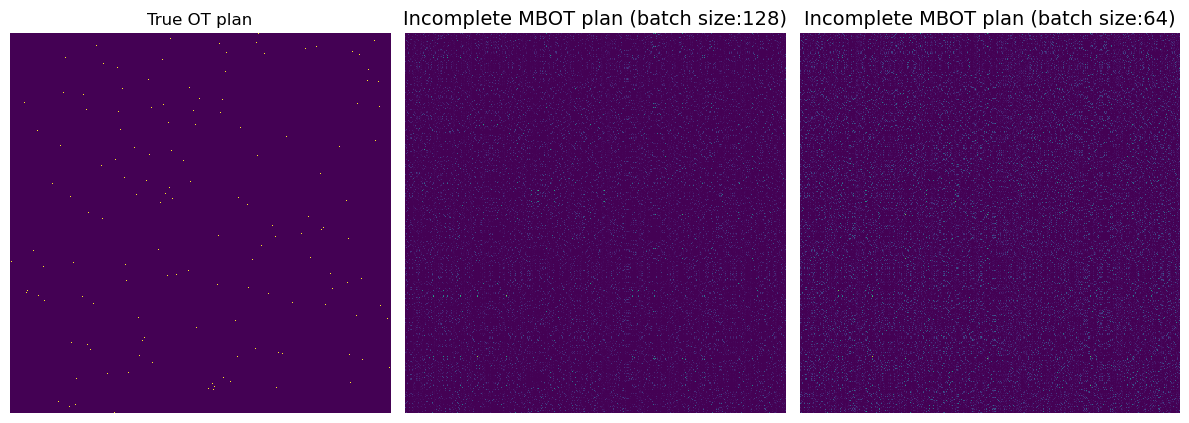

In [5]:
# Visualize OT plans
pl.figure(figsize=(12, 5))

for i in range(3):
    pl.subplot(1, 3, i + 1)
    pl.imshow(np.array(ot_plan_list[i]), interpolation="nearest")
    pl.axis("off")
    if i == 0:
        pl.title("True OT plan")
    else:
        batch_size = batch_size_list[i - 1]
        pl.title(f"Incomplete MBOT plan (batch size:{batch_size})", fontsize=14)
    pl.tight_layout()
plt.show()


# Training OT-CFM with different OT plans

Now that we know how to define the minibatch OT plan, we can compare their respective influence on our OT-CFM method. We will train OT-CFM with the exact OT plan and with two MBOT plans for minibatch sizes of 128 and 64.


Plan 1: loss 0.723 time 72.90
Plan 2: loss 2.440 time 73.36
Plan 3: loss 2.128 time 73.66


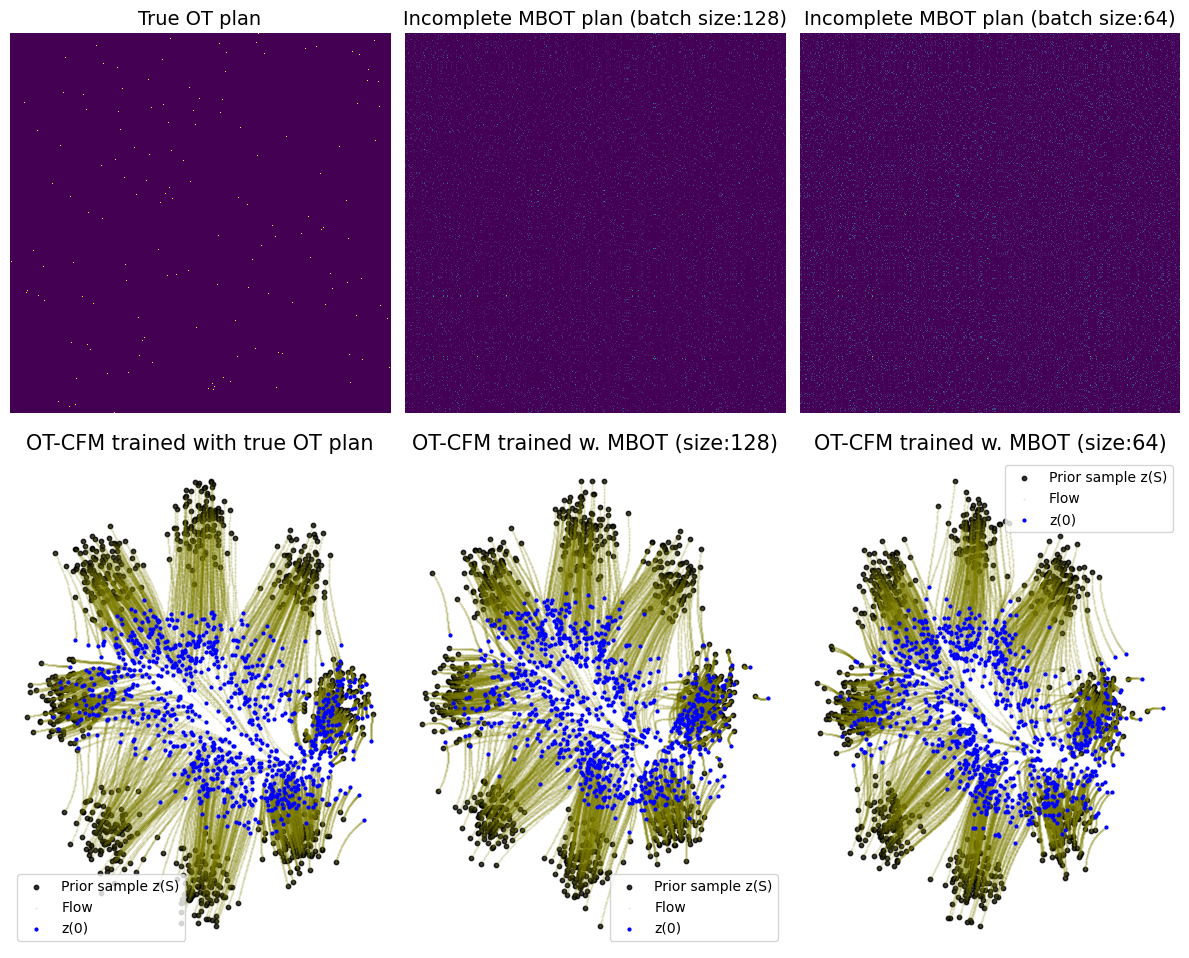

CPU times: user 3min 49s, sys: 1min 31s, total: 5min 21s
Wall time: 3min 57s


In [6]:
%%time
import optax
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt

sigma = 0.1
dim = 2
batch_size = 128
learning_rate = 1e-3

pl.figure(figsize=(12, 10))

for i, mbot_plan in enumerate(ot_plan_list):
    # Initialize model
    key = random.PRNGKey(i)
    model = MLP(dim=dim + 1, out_dim=dim, w=64, time_varying=False)
    key, subkey = random.split(key)
    dummy_input = jnp.ones((batch_size, dim + 1))
    params = model.init(subkey, dummy_input)
    
    # Initialize optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    # Initialize flow matcher
    FM = ConditionalFlowMatcher(sigma=sigma)
    
    # Training step
    @jax.jit
    def train_step(params, opt_state, x0_batch, x1_batch, key):
        key, subkey = random.split(key)
        t, xt, ut = FM.sample_location_and_conditional_flow(subkey, x0_batch, x1_batch)
        model_input = jnp.concatenate([xt, t[:, None]], axis=-1)
        
        def loss_fn(params):
            vt = model.apply(params, model_input)
            return jnp.mean((vt - ut) ** 2)
        
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, key
    
    # Sample from OT plan
    def sample_from_plan(key, pi, batch_size):
        """Sample indices from OT plan."""
        p = pi.flatten()
        p = p / p.sum()
        choices = random.choice(key, pi.shape[0] * pi.shape[1], p=p, shape=(batch_size,), replace=False)
        i, j = jnp.divmod(choices, pi.shape[1])
        return i, j
    
    start = time.time()
    for k in range(20000):
        key, subkey1, subkey2 = random.split(key, 3)
        indices_i, indices_j = sample_from_plan(subkey1, mbot_plan, batch_size)
        batch_x0, batch_x1 = x0[indices_i], x1[indices_j]
        params, opt_state, loss, key = train_step(params, opt_state, batch_x0, batch_x1, subkey2)
    
    end = time.time()
    print(f"Plan {i+1}: loss {loss:.3f} time {(end - start):.2f}")
    
    # Generate trajectory
    key, subkey = random.split(key)
    x0_init = sample_8gaussians(subkey, total_sample)
    
    def vector_field(t, y, args):
        t_batch = jnp.full((y.shape[0],), t)
        model_input = jnp.concatenate([y, t_batch[:, None]], axis=-1)
        return model.apply(params, model_input)
    
    term = ODETerm(vector_field)
    solver = Tsit5()
    saveat = SaveAt(ts=jnp.linspace(0, 1, 100))
    
    # Solve in batches
    traj_list = []
    for j in range(0, total_sample, batch_size):
        batch_x0 = x0_init[j:j+batch_size]
        solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.01, y0=batch_x0, saveat=saveat)
        traj_list.append(solution.ys)
    
    traj = jnp.concatenate(traj_list, axis=1)
    traj_np = np.array(traj)
    
    # Plot
    pl.subplot(2, 3, i + 1)
    pl.imshow(np.array(mbot_plan), interpolation="nearest")
    pl.axis("off")
    if i == 0:
        pl.title("True OT plan", fontsize=14)
    else:
        bs = batch_size_list[i - 1]
        pl.title(f"Incomplete MBOT plan (batch size:{bs})", fontsize=14)
    
    plt.subplot(2, 3, i + 4)
    plt.scatter(traj_np[0, :total_sample, 0], traj_np[0, :total_sample, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj_np[:, :total_sample, 0], traj_np[:, :total_sample, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj_np[-1, :total_sample, 0], traj_np[-1, :total_sample, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    pl.axis("off")
    if i == 0:
        pl.title("OT-CFM trained with true OT plan", fontsize=15)
    else:
        bs = batch_size_list[i - 1]
        pl.title(f"OT-CFM trained w. MBOT (size:{bs})", fontsize=15)
    pl.tight_layout()

plt.show()


## SB-CFM: OT-CFM trained with Entropic OT

In the upcoming section, we proceed to train OT-CFM with the entropic OT (EOT) plan. The EOT plan is the solution of the following problem:

$$\Pi_{\varepsilon} = \text{argmin}_{\Pi \in U(\alpha, \beta)} \langle \Pi, C \rangle - \varepsilon H(\Pi),$$

where $H$ is the entropy function.

We aim to assess the impact of various entropically-regularized OT plans on the inference of our OT-CFM method. Specifically, we explore three different regularization strengths: $\varepsilon=\{1, 10, 100\}$.


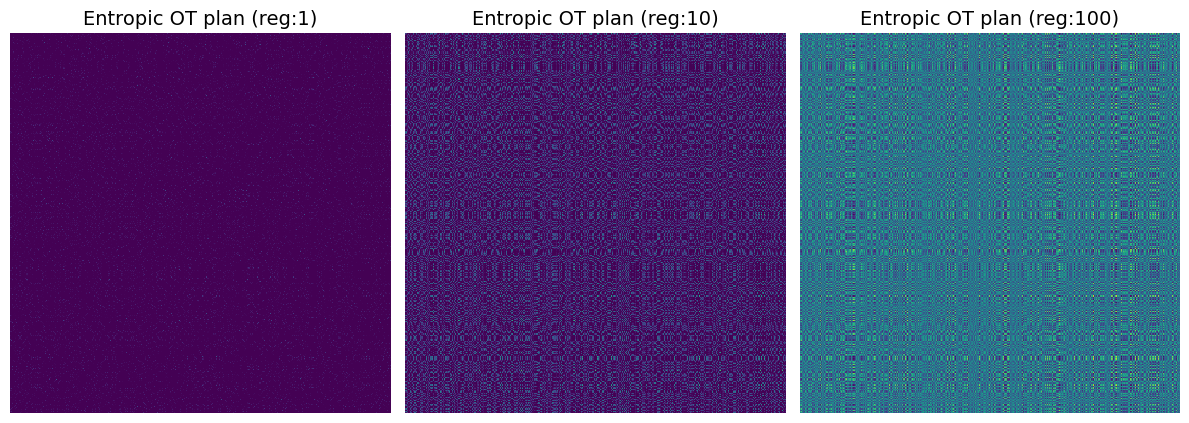

In [7]:
reg_list = [1, 10, 100]

pl.figure(figsize=(12, 5))

key = random.PRNGKey(42)
x0 = sample_8gaussians(key, 1000)
x1 = sample_moons(1000)

entropic_ot_plan_list = []

for i, reg in enumerate(reg_list):
    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)
    entropic_ot_plan = ot_sampler.get_map(x0, x1)
    entropic_ot_plan_list.append(entropic_ot_plan)
    pl.subplot(1, 3, i + 1)
    pl.imshow(np.array(entropic_ot_plan), interpolation="nearest")
    pl.axis("off")
    pl.title(f"Entropic OT plan (reg:{reg})", fontsize=14)
    pl.tight_layout()

plt.show()
